In [20]:
import random
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from info_nce import InfoNCE
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Can either be "autoencoder" or "contrastive" 
strategy = "contrastive"

In [21]:
def set_seed(seed):
    torch.manual_seed(seed)  # Sets the seed for CPU operations
    torch.cuda.manual_seed(seed)  # Sets the seed for CUDA GPU operations
    torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
    random.seed(seed)  # Python's random library
    np.random.seed(seed)  # NumPy
    
    # For determinism in certain CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
# Load
df_a = pd.read_parquet('../../data/set-a-imputed-scaled.parquet').sort_values(by=['RecordID','Time'])
df_b = pd.read_parquet('../../data/set-b-imputed-scaled.parquet').sort_values(by=['RecordID','Time'])
df_c = pd.read_parquet('../../data/set-c-imputed-scaled.parquet').sort_values(by=['RecordID','Time'])


# Get labels
outcomes_a = pd.read_csv('../../data/Outcomes-a.txt').sort_values(by=['RecordID'])[['RecordID', 'In-hospital_death']]
outcomes_b = pd.read_csv('../../data/Outcomes-b.txt').sort_values(by=['RecordID'])[['RecordID', 'In-hospital_death']]
outcomes_c = pd.read_csv('../../data/Outcomes-c.txt').sort_values(by=['RecordID'])[['RecordID', 'In-hospital_death']]


# Drop time
df_a = df_a.drop(columns=['Time'])
df_b = df_b.drop(columns=['Time'])
df_c = df_c.drop(columns=['Time'])


# Group by 'Category'
df_a = df_a.groupby('RecordID')
df_c = df_c.groupby('RecordID')


# Convert groups into stacked tensor (dropping the group column dynamically)
X_train = torch.stack([torch.tensor(group.drop(columns='RecordID').values, dtype=torch.float32) for _, group in df_a])  # Stack into a 3D tensor
X_test = torch.stack([torch.tensor(group.drop(columns='RecordID').values, dtype=torch.float32) for _, group in df_c])  

y_train = torch.tensor(outcomes_a.drop(columns=['RecordID']).values, dtype=torch.float32)
y_test = torch.tensor(outcomes_c.drop(columns=['RecordID']).values, dtype=torch.float32)


train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [23]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, dropout, bidirectional):
        super(LSTMAutoencoder, self).__init__()
        # Encoder
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
        if bidirectional:
            hidden_size = hidden_size * 2
        
        # Decoder
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=input_dim,  # Reconstructing back to the original input dimension
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False  # Decoding doesn't need bidirectionality
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        
        # Encoding phase
        encoded_lstm_out, _ = self.encoder_lstm(x)
        # We only want the output from the last time step (representation vector)
        representation = encoded_lstm_out[:, -1, :]  # Shape: (batch_size, hidden_dim)
        
        # Decoding phase
        # Expanding the representation to sequence dimension for reconstruction
        representation_expanded = representation.unsqueeze(1).repeat(1, x.size(1), 1)
        decoded_lstm_out, _ = self.decoder_lstm(representation_expanded)
        
        return decoded_lstm_out  # Reconstructed output (shape: batch_size, seq_len, input_dim)

In [24]:
# Define the LSTM classifier
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_size, projection_size,  num_layers, dropout, bidirectional):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
        if bidirectional:
            hidden_size = hidden_size * 2
                # Projection layer (to map the LSTM output to a different space)
        self.projection_layer = nn.Linear(hidden_size, projection_size)
        
        # Activation function (optional, depending on your task)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # We only want the output from the last time step
        last_time_step_out = lstm_out[:, -1, :]
        # Apply the projection layer
        projection_out = self.projection_layer(last_time_step_out)
        
        # Optionally apply a non-linear activation (e.g., ReLU)
        projected_embedding = self.relu(projection_out)
        
        return projected_embedding

In [25]:
# Define the LSTM classifier
class SupervisedLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, num_classes, dropout, bidirectional):
        super(SupervisedLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
        if bidirectional:
            hidden_size = hidden_size * 2
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # We only want the output from the last time step
        last_time_step_out = lstm_out[:, -1, :]
        out = self.fc(last_time_step_out)
        out = self.sigmoid(out)
        return out

In [26]:
# Scale: Multiply each time series by a small random factor
def scale(x, sigma=0.1):
    scaling_factor = torch.normal(mean=1.0, std=sigma, size=(x.shape[0], 1, 1)).to(x.device)
    return x * scaling_factor

# Jitter: Add small Gaussian noise
def jitter(x, sigma=0.02):
    noise = torch.normal(mean=0.0, std=sigma, size=x.shape).to(x.device)
    return x + noise

def permutation(x):
    seq_len = x.shape[1]
    
    # Calculate the segment sizes: 3 segments of size 12, and 1 segment of size 13
    segment_sizes = [12] * 3 + [13]  # Three segments of size 12 and one of size 13
    assert sum(segment_sizes) == seq_len, "Total segment size must equal sequence length"
    
    indices = torch.arange(seq_len)
    segments = []
    start_idx = 0

    # Create the segments based on the segment_sizes
    for size in segment_sizes:
        segments.append(indices[start_idx:start_idx+size])
        start_idx += size
    
    # Shuffle the segments (without modifying the individual segments)
    permuted_segments = torch.randperm(len(segments))
    shuffled_indices = torch.cat([segments[i] for i in permuted_segments])

    # Apply the shuffled indices to the input sequence
    return x[:, shuffled_indices, :]

# Weak augmentation: Scale + Jitter
def weak_augmentation(x):
    return jitter(scale(x, sigma=0.1), sigma=0.02)

# Strong augmentation: Jitter + Permutation
def strong_augmentation(x):
    return permutation(jitter(x, sigma=0.05))

In [27]:
set_seed(42)

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Hyperparameters
# We take parameters from previous question to allow a fair comparison
input_dim = 41
hidden_dim = 256
num_layers = 2
# num_layers = 4
dropout = 0.18640091013719517
bidirectional = False
# bidirectional = True
epochs = 25
learning_rate = 0.001



# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if strategy == "autoencoder":
    model = LSTMAutoencoder(
        input_dim, 
        hidden_dim, 
        num_layers, 
        dropout, 
        bidirectional
    ).to(device)
    criterion = nn.MSELoss()
elif strategy == "contrastive":
    projection_dim = 32
    model = LSTMEncoder(
        input_dim,
        hidden_dim,
        projection_dim,
        num_layers,
        dropout,
        bidirectional
    ).to(device)
    criterion = InfoNCE()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        if strategy == "contrastive":
            # Apply weak and strong augmentations
            x1 = weak_augmentation(batch_X)  # Weak augmented version
            x2 = strong_augmentation(batch_X)  # Strong augmented version

            # Get embeddings from the model
            z1 = model(x1)  # Embedding for the first augmented batch
            z2 = model(x2)  # Embedding for the second augmented batch
        else:
            out = model(batch_X)  # Embedding for the second augmented batch

        optimizer.zero_grad()

        if strategy == "contrastive":
            loss = criterion(z1, z2)
        else:
            loss = criterion(batch_X, out)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")

Epoch [1/25], Loss: 0.4997
Epoch [2/25], Loss: 0.4814
Epoch [3/25], Loss: 0.2682
Epoch [4/25], Loss: 0.1932
Epoch [5/25], Loss: 0.1738
Epoch [6/25], Loss: 0.1565
Epoch [7/25], Loss: 0.1458
Epoch [8/25], Loss: 0.1263
Epoch [9/25], Loss: 0.1472
Epoch [10/25], Loss: 0.1021
Epoch [11/25], Loss: 0.0923
Epoch [12/25], Loss: 0.0810
Epoch [13/25], Loss: 0.0978
Epoch [14/25], Loss: 0.1119
Epoch [15/25], Loss: 0.0862
Epoch [16/25], Loss: 0.0997
Epoch [17/25], Loss: 0.0882
Epoch [18/25], Loss: 0.0760
Epoch [19/25], Loss: 0.0666
Epoch [20/25], Loss: 0.0627
Epoch [21/25], Loss: 0.0544
Epoch [22/25], Loss: 0.0648
Epoch [23/25], Loss: 0.1113
Epoch [24/25], Loss: 0.0881
Epoch [25/25], Loss: 0.0762
Training complete!


In [28]:
# Assuming `model` is your pretrained LSTM model
for param in model.parameters():
    param.requires_grad = False  # Freeze the LSTM model parameters

In [29]:
# Assuming `data_loader` is your DataLoader for the dataset
train_embeddings = []
train_labels = []


print(len(train_dataset))

# Extract embeddings for each patient
for i in range(len(train_dataset)):
    with torch.no_grad():  # No need to compute gradients here
        X, y = train_dataset[i]
        X, y = X.to(device), y.to(device)
        X, y = X.unsqueeze(0), y.unsqueeze(0)

        if strategy == "autoencoder":
            encoded_lstm_out, (h_n, cell) = model.encoder_lstm(X)
            train_embeddings.append(h_n[-1])  # Use last layer hidden state
        else:
            lstm_out = model(X)
            train_embeddings.append(lstm_out)
        
        train_labels.append(y)

# Convert embeddings and labels into tensors (assuming batch_y is already a tensor)
train_embeddings = torch.cat(train_embeddings, dim=0)
train_labels = torch.cat(train_labels, dim=0)

print(train_embeddings.shape)
print(train_labels.shape)

4000
torch.Size([4000, 32])
torch.Size([4000, 1])


In [30]:
# Convert to numpy for scikit-learn
train_embeddings_np = train_embeddings.cpu().numpy()  # Convert embeddings to numpy
train_labels_np = train_labels.cpu().numpy()  # Convert labels to numpy

# Train a logistic regression model using sklearn
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(train_embeddings_np, train_labels_np)

/mnt/c/Users/Elias/OneDrive - ETH Zurich/2025SS/Machine Learning for Healthcare/MLH4-Project-1/testvenv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000, random_state=42)

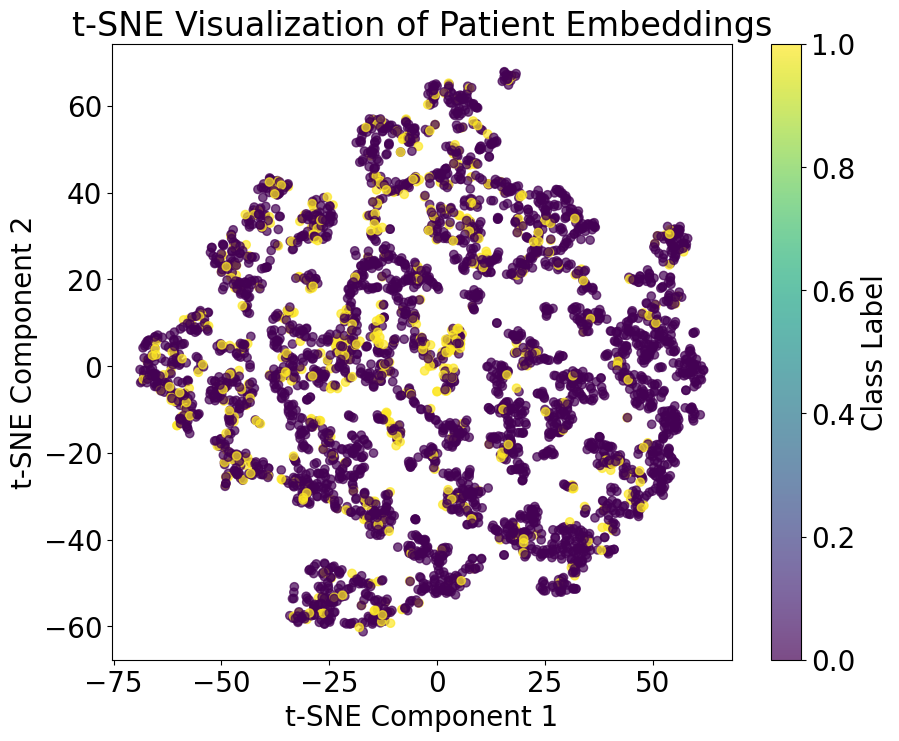

Silhouette Score: -0.0134
Davies-Bouldin Index: 6.0988


/mnt/c/Users/Elias/OneDrive - ETH Zurich/2025SS/Machine Learning for Healthcare/MLH4-Project-1/testvenv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/c/Users/Elias/OneDrive - ETH Zurich/2025SS/Machine Learning for Healthcare/MLH4-Project-1/testvenv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
plt.rcParams.update({'font.size': 20}) 

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # You can tune perplexity
embeddings_2d = tsne.fit_transform(train_embeddings_np)  # Shape: (4000, 2)

# Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=train_labels_np, cmap='viridis', alpha=0.7)
plt.colorbar(label="Class Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Patient Embeddings")
plt.show()


# Compute Silhouette Score
sil_score = silhouette_score(embeddings_2d, train_labels_np)

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(embeddings_2d, train_labels_np)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

In [32]:
# Assuming `data_loader` is your DataLoader for the dataset
test_embeddings = []
test_labels = []


print(len(test_dataset))

# Extract embeddings for each patient
for i in range(len(test_dataset)):
    with torch.no_grad():  # No need to compute gradients here
        X, y = test_dataset[i]
        X, y = X.to(device), y.to(device)
        X, y = X.unsqueeze(0), y.unsqueeze(0)

        if strategy == "autoencoder":
            encoded_lstm_out, (h_n, cell) = model.encoder_lstm(X)
            test_embeddings.append(h_n[-1])  # Use last layer hidden state
        else:
            lstm_out = model(X)
            test_embeddings.append(lstm_out)

        test_labels.append(y)

# Convert embeddings and labels into tensors (assuming batch_y is already a tensor)
test_embeddings = torch.cat(test_embeddings, dim=0)
test_labels = torch.cat(test_labels, dim=0)

print(test_embeddings.shape)
print(test_labels.shape)

4000
torch.Size([4000, 32])
torch.Size([4000, 1])


In [33]:
# Convert to numpy for scikit-learn
test_embeddings_np = test_embeddings.cpu().numpy()  # Convert embeddings to numpy
labels_np = test_labels.cpu().numpy()  # Convert labels to numpy


# Now, evaluate the model
predictions = log_reg.predict(test_embeddings_np)
test_probs = log_reg.predict_proba(test_embeddings_np)[:, 1]  # Probabilities for the positive class

# Compute accuracy
accuracy = accuracy_score(labels_np, predictions)
print(f"Logistic Regression accuracy: {accuracy}")

# Compute AUROC and AUPRC for the test set
train_auroc = roc_auc_score(labels_np, test_probs)
train_auprc = average_precision_score(labels_np, test_probs)
print(f"Test AUROC: {train_auroc}")
print(f"Test AUPRC: {train_auprc}")

Logistic Regression accuracy: 0.85575
Test AUROC: 0.6662907484576591
Test AUPRC: 0.2780580173352493


In [34]:
# Generate new training sets
subset_100_indices = torch.randperm(len(train_dataset))[:100]
subset_500_indices = torch.randperm(len(train_dataset))[:500]
subset_1000_indices = torch.randperm(len(train_dataset))[:1000]

train_dataset_100 = Subset(train_dataset, subset_100_indices)
train_dataset_500 = Subset(train_dataset, subset_500_indices)
train_dataset_1000 = Subset(train_dataset, subset_1000_indices)

# New DataLoaders
train_loader_100 = DataLoader(train_dataset_100, batch_size=8, shuffle=True)
train_loader_500 = DataLoader(train_dataset_500, batch_size=8, shuffle=True)
train_loader_1000 = DataLoader(train_dataset_1000, batch_size=8, shuffle=True)

# Train three different supervised models
model_dict = {
    "100": SupervisedLSTMClassifier(input_dim, hidden_dim, num_layers, 1, dropout, False).to(device),
    "500": SupervisedLSTMClassifier(input_dim, hidden_dim, num_layers, 1, dropout, False).to(device),
    "1000": SupervisedLSTMClassifier(input_dim, hidden_dim, num_layers, 1, dropout, False).to(device)
}

dataloader_dict = {
    "100": train_loader_100,
    "500": train_loader_500,
    "1000": train_loader_1000
}

supervised_result_dict = {}


In [35]:
for num_samples, model in model_dict.items():
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = dataloader_dict[num_samples]
    epochs=10
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    #     print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
    # print("Training complete!")

    # Evaluation loop
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            # Get probabilities (if using softmax for multi-class or sigmoid for binary)
            probs = outputs


            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Compute metrics
    average_loss = total_loss / len(test_loader)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    supervised_result_dict[num_samples] = {
        "auroc": auroc,
        "aurpc": auprc
    }

    print(f"Test AuROC ({num_samples}): {auroc:.4f}")
    print(f"Test AuPRC ({num_samples}): {auprc:.4f}")


print(supervised_result_dict)


Test AuROC (100): 0.7278
Test AuPRC (100): 0.3326
Test AuROC (500): 0.7867
Test AuPRC (500): 0.3829
Test AuROC (1000): 0.7633
Test AuPRC (1000): 0.3795
{'100': {'auroc': 0.7277523745166498, 'aurpc': 0.3326127477988632}, '500': {'auroc': 0.7867342418440515, 'aurpc': 0.3829393783051378}, '1000': {'auroc': 0.7632984194916845, 'aurpc': 0.3794524973605751}}


In [36]:
indices_100 = np.random.choice(len(train_embeddings_np), size=100, replace=False)
indices_500 = np.random.choice(len(train_embeddings_np), size=500, replace=False)
indices_1000 = np.random.choice(len(train_embeddings_np), size=1000, replace=False)

data_dict = {
    "100": (train_embeddings_np[indices_100], train_labels_np[indices_100]),
    "500": (train_embeddings_np[indices_500],  train_labels_np[indices_500]),
    "1000": (train_embeddings_np[indices_1000], train_labels_np[indices_1000])
}

model_dict = {
    "100": LogisticRegression(max_iter=1000, random_state=42),
    "500": LogisticRegression(max_iter=1000, random_state=42),
    "1000": LogisticRegression(max_iter=1000, random_state=42)
}


linear_result_dict = {}

In [37]:
for num_samples, model in model_dict.items():
    X, y = data_dict[num_samples]
    print(X.shape, y.shape)
    model.fit(X, y)

    # Now, evaluate the model
    predictions = model.predict(test_embeddings_np)
    test_probs = model.predict_proba(test_embeddings_np)[:, 1]  # Probabilities for the positive class

    # Compute AUROC and AUPRC for the test set
    auroc = roc_auc_score(labels_np, test_probs)
    auprc = average_precision_score(labels_np, test_probs)
    
    
    linear_result_dict[num_samples] = {
        "auroc": auroc,
        "aurpc": auprc
    }

    print(f"Test AuROC ({num_samples}): {auroc:.4f}")
    print(f"Test AuPRC ({num_samples}): {auprc:.4f}")




print(linear_result_dict)

(100, 32) (100, 1)
Test AuROC (100): 0.5808
Test AuPRC (100): 0.1797
(500, 32) (500, 1)


/mnt/c/Users/Elias/OneDrive - ETH Zurich/2025SS/Machine Learning for Healthcare/MLH4-Project-1/testvenv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/c/Users/Elias/OneDrive - ETH Zurich/2025SS/Machine Learning for Healthcare/MLH4-Project-1/testvenv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test AuROC (500): 0.5956
Test AuPRC (500): 0.2259
(1000, 32) (1000, 1)


/mnt/c/Users/Elias/OneDrive - ETH Zurich/2025SS/Machine Learning for Healthcare/MLH4-Project-1/testvenv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test AuROC (1000): 0.6354
Test AuPRC (1000): 0.2633
{'100': {'auroc': 0.580841185819224, 'aurpc': 0.17967930219612074}, '500': {'auroc': 0.5956241318466794, 'aurpc': 0.22587577890686675}, '1000': {'auroc': 0.6354484363854789, 'aurpc': 0.26330637112609023}}


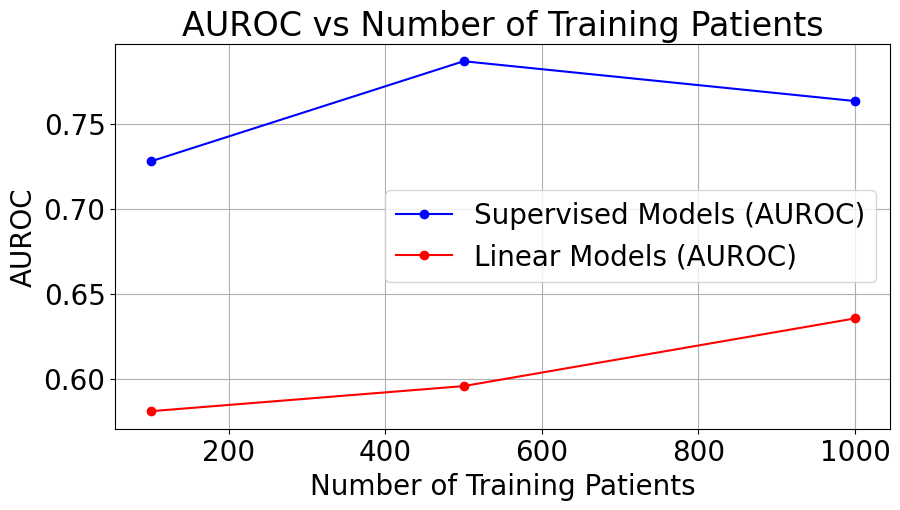

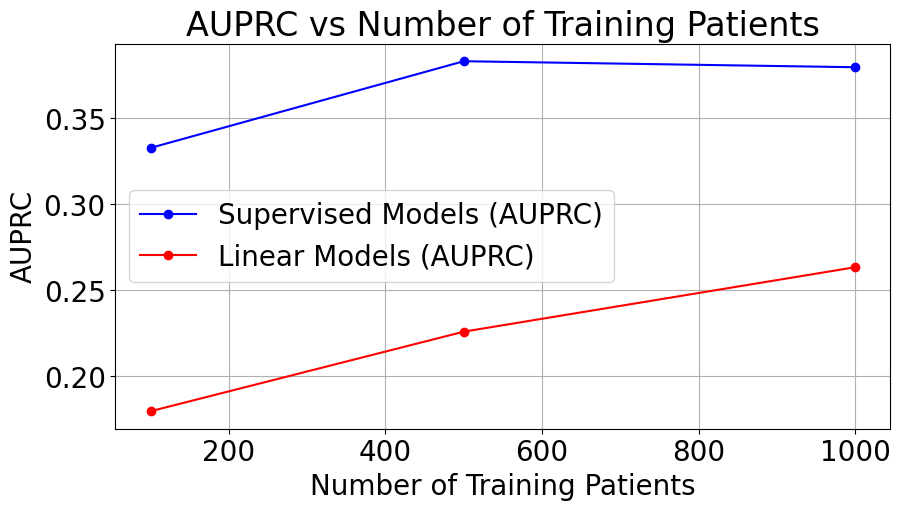

In [38]:
# Extract training sizes and metrics
training_sizes = [int(k) for k in supervised_result_dict.keys()]  # [100, 500, 1000]

# Supervised model metrics
supervised_auroc = [supervised_result_dict[str(size)]['auroc'] for size in training_sizes]
supervised_aurpc = [supervised_result_dict[str(size)]['aurpc'] for size in training_sizes]

# Linear model metrics
linear_auroc = [linear_result_dict[str(size)]['auroc'] for size in training_sizes]
linear_aurpc = [linear_result_dict[str(size)]['aurpc'] for size in training_sizes]

plt.rcParams.update({'font.size': 20}) 

# Plot AUROC
plt.figure(figsize=(10, 5))
plt.plot(training_sizes, supervised_auroc, marker='o', label='Supervised Models (AUROC)', color='blue')
plt.plot(training_sizes, linear_auroc, marker='o', label='Linear Models (AUROC)', color='red')
plt.xlabel('Number of Training Patients')
plt.ylabel('AUROC')
plt.title('AUROC vs Number of Training Patients')
plt.grid(True)
plt.legend()
plt.show()

# Plot AUPRC
plt.figure(figsize=(10, 5))
plt.plot(training_sizes, supervised_aurpc, marker='o', label='Supervised Models (AUPRC)', color='blue')
plt.plot(training_sizes, linear_aurpc, marker='o', label='Linear Models (AUPRC)', color='red')
plt.xlabel('Number of Training Patients')
plt.ylabel('AUPRC')
plt.title('AUPRC vs Number of Training Patients')
plt.grid(True)
plt.legend()
plt.show()